#K2BrightsCamp6

####Checking for Targets in Campaign 6

In [2]:
import K2fov
import hipparchos2io as hip2
from hipparchos2io.hip2 import reader as hipreader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
#http://matplotlib.org/users/customizing.html
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 12.}

plt.rc('font', **font)  # pass in the font dict as kwargs
axes = {'labelsize' : 12.,
        'linewidth' : 2.,
        'labelweight' : 'bold'}
plt.rc('axes', **axes)  # pass in the font dict as kwargs
plt.rc('text', usetex=False)

myfigsize = (12.0, 8.0)
myfontsize = 10.
plt.rcParams['figure.figsize'] = myfigsize

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

####Read in the Hipparcos Data

In [5]:
#determine the hip library directory:
hip2dir = '/'.join(hip2.__file__.split('/')[:-1])+'/'

#read in all the hipparcos data to a list of star objects:
stars = hipreader.get_stars_list(hip2dir+'hip2_data/hip2.dat')

#now cycle through the hip data, adding it to the DataFrame
stararr = [{'hipid': star.hipparcos_id,
            'ra': star.ra_radians,
           'dec': star.dec_radians,
           'plx': star.parallax_mas,
           'pmra': star.proper_motion_ra_mas_per_year,
           'pmdec': star.proper_motion_dec_mas_per_year,
           'era': star.ra_error_mas,
           'edec': star.dec_error_mas,
           'eplx': star.parallax_error_mas,
           'epmra': star.proper_motion_ra_error_mas_per_year,
           'epmdec': star.proper_motion_dec_error_mas_per_year,
           'mag': star.magnitude,
           'emag': star.magnitude_error,
           'bv': star.color_index,
           'ebv': star.color_index_error,
           'vi': star.VI_color_index} for star in stars]

#create a pandas DataFrame for the hip data:
hip_df = pd.DataFrame(stararr)

hip_df['absmag'] = hip_df['mag'] - 5. * np.log10(100./hip_df['plx'])


#### Only look at the targets observable by CHIRON and K2

In [23]:
hip_close = hip_df[((hip_df['plx'] >= 10) & (hip_df['bv'] != 0))]
ralorad = 190 / 180. * np.pi
rahirad = 220 / 180. * np.pi
dechirad = 0 / 180. * np.pi
declorad = -20 / 180. * np.pi
hip_camp = hip_close[((hip_close['mag'] < 8) & 
                       (hip_close['ra'] > ralorad) &
                       (hip_close['ra'] < rahirad) &
                       (hip_close['dec'] < dechirad) &
                       (hip_close['dec'] > declorad) & 
                       (hip_close['bv'] > 0.55) &
                       (hip_close['absmag'] > 1.1))].copy()

hip_camp['radeg'] = hip_camp['ra'] * 180. / np.pi
hip_camp['decdeg'] = hip_camp['dec'] * 180. / np.pi

len(hip_camp)

41

(20, -5)

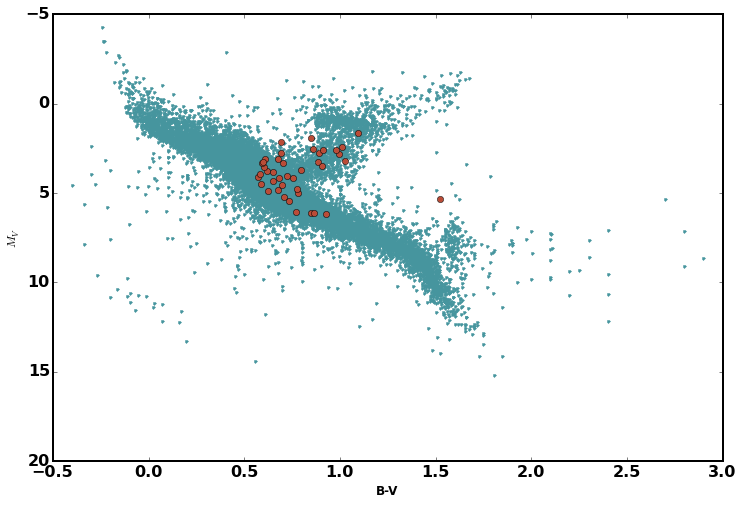

In [24]:
plt.plot(hip_close['bv'], hip_close['absmag'], '.', color='#46959E')
plt.plot(hip_camp['bv'], hip_camp['absmag'], 'o', color='#BA4C37')
plt.xlabel('B-V')
plt.ylabel('$M_{V}$')
plt.ylim([20, -5])

###Checking on Silicon

,hipid,radeg,decdeg,bv,mag,absmag,onSilicon
64417,64638,198.732718,-11.368701,0.683,7.1553,4.186297,2
65891,66115,203.297728,-8.443464,0.624,7.4820,4.906345,2


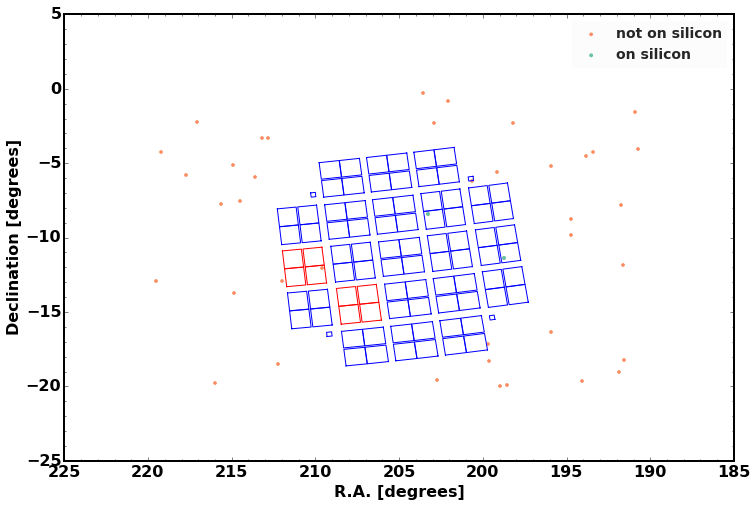

In [25]:
#Method 2

#ENTER THE CAMPAIGN NUMBER:
fieldnum = 6

ra_sources_deg, dec_sources_deg, mag = (hip_camp['radeg'].values,
                                       hip_camp['decdeg'].values,
                                       hip_camp['mag'].values)

from K2fov.K2onSilicon import getRaDecRollFromFieldnum
from K2fov.K2onSilicon import onSiliconCheck
from K2fov.K2onSilicon import nearSiliconCheck
import K2fov.fov as fov
import K2fov.projection as proj

ra_deg, dec_deg, scRoll_deg = getRaDecRollFromFieldnum(fieldnum)
fovRoll_deg = fov.getFovAngleFromSpacecraftRoll(scRoll_deg)
k = fov.KeplerFov(ra_deg, dec_deg, fovRoll_deg)
raDec = k.getCoordsOfChannelCorners()

onSilicon = map(onSiliconCheck,
    ra_sources_deg,dec_sources_deg,np.repeat(k,len(ra_sources_deg)))

nearSilicon = map(nearSiliconCheck,
    ra_sources_deg,dec_sources_deg,np.repeat(k,len(ra_sources_deg)))

onSilicon = np.array(onSilicon,dtype=bool)
nearSilicon = np.array(nearSilicon, dtype=bool)

#the plotting bit:
almost_black = '#262626'
light_grey = np.array([float(248)/float(255)]*3)
#ph = proj.Gnomic(ra_deg, dec_deg)
ph = proj.PlateCaree()
k.plotPointing(ph,showOuts=False,plot_degrees=False)
targets = ph.skyToPix(ra_sources_deg, dec_sources_deg)
targets = np.array(targets ) #* 180 / np.pi
fig = plt.gcf()
ax = fig.gca()
ax = fig.add_subplot(111)
#ax.scatter(*targets,s=2,label='not on silicon')
ax.scatter(*targets,color='#fc8d62',s=7,label='not on silicon')
ax.scatter(targets[0][onSilicon],
    targets[1][onSilicon],color='#66c2a5',s=8,label='on silicon')
ax.set_xlabel('R.A. [degrees]',fontsize=16)
ax.set_ylabel('Declination [degrees]',fontsize=16)
ax.invert_xaxis()
ax.minorticks_on()
legend = ax.legend(loc=0,
    frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_alpha(0.3)
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)
texts = legend.texts
for t in texts:
    t.set_color(almost_black)

siliconFlag = np.zeros_like(ra_sources_deg)

#prints zero if target is not on silicon
siliconFlag = np.where(nearSilicon,0,siliconFlag)

#prints a 2 if target is on silicon
siliconFlag = np.where(onSilicon,2,siliconFlag)

hip_camp['onSilicon'] = siliconFlag

hip_camp_good = hip_camp[hip_camp['onSilicon'] == 2]

hip_camp_good[['hipid', 'radeg', 'decdeg', 'bv', 'mag', 'absmag', 'onSilicon']]